# Install library

In [22]:
import os
import random

import numpy as np
import pandas as pd
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import KFold, StratifiedKFold

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.layers import Input, Dense, Conv2D, Activation
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
def set_randvalue(value):
    # Set a seed value
    seed_value= value 
    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)
    # 2. Set `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)
    # 3. Set `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)
    # 4. Set `tensorflow` pseudo-random generator at a fixed value
    tf.random.set_seed(seed_value)

set_randvalue(42)

## Dataset preprocessing and EDA

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data() # load data
x_train,x_test = x_train.astype('float32')/255.0,x_test.astype('float32')/255.0 # normalization

In [4]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [5]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

#### Limit three class preprocessing

In [6]:
# No method on keras to get cifar10 category label name by categoly label?
cifar10_labels = np.array([
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'])

bird_num = np.where(cifar10_labels=='bird')
deer_num = np.where(cifar10_labels=='deer')
truck_num = np.where(cifar10_labels=='truck')

limit_num = 2500

# get limit label indexes
bird_indexes = [i for i, label in enumerate(y_train) if label == bird_num]
deer_indexes = [i for i, label in enumerate(y_train) if label == deer_num] 
truck_indexes = [i for i, label in enumerate(y_train) if label == truck_num] 
other_indexes = [i for i, label in enumerate(y_train) if label not in [bird_num, deer_num, truck_num]]

# limit
bird_indexes = bird_indexes[:limit_num]
deer_indexes = deer_indexes[:limit_num]
truck_indexes = truck_indexes[:limit_num]
print(f'Bird label num is {len(bird_indexes)}') # 2500
print(f'Deer label num is {len(deer_indexes)}') # 2500
print(f'Truck label num is {len(truck_indexes)}') # 2500
print(f'Other label num is {len(other_indexes)}') # 35000; 5000*7

# merge and sort
merge_indexes = np.concatenate([other_indexes, bird_indexes, deer_indexes, truck_indexes], 0)
merge_indexes.sort()
print(f'Train label num is {len(merge_indexes)}') # 42500

# create three labels removed train data
x_train_removed =  np.zeros((len(merge_indexes), 32, 32, 3))
y_train_removed =  np.zeros(len(merge_indexes))

for i, train_index in enumerate(merge_indexes):
    x_train_removed[i] = x_train[train_index]
    y_train_removed[i] = y_train[train_index]
    
print(x_train_removed.shape)
print(y_train_removed.shape)

Bird label num is 2500
Deer label num is 2500
Truck label num is 2500
Other label num is 35000
Train label num is 42500
(42500, 32, 32, 3)
(42500,)


In [60]:
# y_train.shape
# df_train = pd.DataFrame(y_train, columns=['label'])
# index = df_train[df_train['label'] == 2].index
# len(index)
bird_num[0].item()

2

#### Under sampling

In [7]:
# merge and sort
target_indexes = np.concatenate([bird_indexes, deer_indexes, truck_indexes], 0)
target_indexes.sort()
print(f'Target label num is {len(target_indexes)}') # 7500
print(f'Other label num is {len(other_indexes)}') # 35000

# create three labels removed train data
x_train_target =  np.zeros((len(target_indexes), 32, 32, 3))
y_train_target =  np.zeros(len(target_indexes))

for i, train_index in enumerate(target_indexes):
    x_train_target[i] = x_train[train_index]
    y_train_target[i] = y_train[train_index]

x_train_other =  np.zeros((len(other_indexes), 32, 32, 3))
y_train_other =  np.zeros(len(other_indexes))

for i, train_index in enumerate(other_indexes):
    x_train_other[i] = x_train[train_index]
    y_train_other[i] = y_train[train_index]

Target label num is 7500
Other label num is 35000


In [8]:
# df = pd.DataFrame(y_train_removed.flatten())
df = pd.DataFrame(y_train_removed.flatten())
print(df.value_counts())
del df

0.0    5000
1.0    5000
3.0    5000
5.0    5000
6.0    5000
7.0    5000
8.0    5000
2.0    2500
4.0    2500
9.0    2500
dtype: int64


(array([5000., 5000., 2500., 5000., 2500., 5000., 5000., 5000., 5000.,
        2500.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

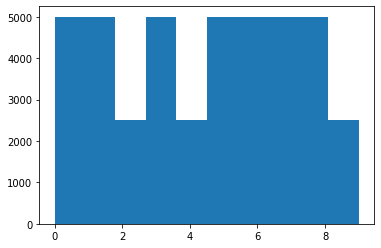

In [9]:
import matplotlib.pyplot as plt

# plot data labels
plt.hist(y_train_removed.flatten())

In [11]:
# train test split
# stratify y label
x_train_target_, x_valid_target_, y_train_target_, y_valid_target_ = train_test_split(x_train_target, y_train_target, 
                                                                      test_size=0.3, random_state=42, stratify=y_train_target)
x_train_other_, x_valid_other_, y_train_other_, y_valid_other_ = train_test_split(x_train_other, y_train_other, 
                                                                      test_size=0.3, random_state=42, stratify=y_train_other)
x_train_other__, x_valid_other__, y_train_other__, y_valid_other__ = train_test_split(x_train_other_, y_train_other_, 
                                                                     test_size=0.5, random_state=42, stratify=y_train_other_)

# Train set 1
x_train_removed1 = np.concatenate([x_train_target_, x_train_other__],0)
x_valid_removed1 = np.concatenate([x_valid_target_, x_valid_other_],0)
y_train_removed1 = np.concatenate([y_train_target_, y_train_other__],0)
y_valid_removed1 = np.concatenate([y_valid_target_, y_valid_other_],0)

# Train set 2
x_train_removed2 = np.concatenate([x_train_target_, x_valid_other__],0)
x_valid_removed2 = np.concatenate([x_valid_target_, x_train_other_],0)
y_train_removed2 = np.concatenate([y_train_target_, y_valid_other__],0)
y_valid_removed2 = np.concatenate([y_valid_target_, y_train_other_],0)

In [12]:
print(x_train_removed1.shape)
print(y_train_removed1.shape)
print(x_valid_removed1.shape)
print(y_valid_removed1.shape)

(17500, 32, 32, 3)
(17500,)
(12750, 32, 32, 3)
(12750,)


In [13]:
df = pd.DataFrame(y_train_removed1.flatten())
print(df.value_counts())
del df

0.0    1750
1.0    1750
2.0    1750
3.0    1750
4.0    1750
5.0    1750
6.0    1750
7.0    1750
8.0    1750
9.0    1750
dtype: int64


In [14]:
df = pd.DataFrame(y_valid_removed1.flatten())
print(df.value_counts())
del df

0.0    1500
1.0    1500
3.0    1500
5.0    1500
6.0    1500
7.0    1500
8.0    1500
2.0     750
4.0     750
9.0     750
dtype: int64


## AutoEncoder

#### Load AE models weight

In [15]:
# Batch Norm Model
def create_AE01_model(k_size):
    input_img = Input(shape=(32, 32, 3))  # 0
    conv1 = Conv2D(64, (k_size, k_size), padding='same', name="Dense_AE01_1")(input_img) # 1
    conv1 = BatchNormalization(name="BN_AE01_1")(conv1) # 2
    conv1 = Activation('relu', name="Relu_AE01_1")(conv1) # 3
        
    decoded = Conv2D(3, (k_size, k_size), padding='same', name="Dense_AE01_2")(conv1) # 4
    decoded = BatchNormalization(name="BN_AE01_2")(decoded) # 5
    decoded = Activation('relu', name="Relu_AE01_2")(decoded) # 6
    return Model(input_img, decoded)

class AE01():
    def __init__(self, ksize, optimizer):
        self.optimizer = optimizer
        
        self.autoencoder = create_AE01_model(ksize)
        self.encoder = None

    def compile(self, optimizer='adam', loss='binary_crossentropy'):
        self.autoencoder.compile(optimizer=self.optimizer, loss=loss)

    def train(self, x_train=None, x_test=None, epochs=1, batch_size=32, shuffle=True):
        es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
        ae_model_path = '../models/AE/AE01_AE_Best.hdf5'
        cp_cb = ModelCheckpoint(filepath = ae_model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
       
        history = self.autoencoder.fit(x_train, x_train,
                             epochs=epochs,
                             batch_size=batch_size,
                             shuffle=shuffle,
                             callbacks=[es_cb, cp_cb],
                             validation_data=(x_test, x_test))
        
        self.autoencoder.load_weights(ae_model_path)
        
        self.encoder = Model(self.autoencoder.input, self.autoencoder.get_layer('Relu_AE01_1').output)
        encode_model_path = '../models/AE/AE01_Encoder_Best.hdf5'
        self.encoder.save(encode_model_path)
        return history
    
    def load_weights(self, ae_model_path, encode_model_path):
        self.autoencoder.load_weights(ae_model_path)
        self.encoder = Model(self.autoencoder.input, self.autoencoder.get_layer('Relu_AE01_1').output)
        self.encoder.load_weights(encode_model_path)

In [16]:
ae_ksize = 3
ae_optimizer = 'rmsprop'
stack01 = AE01(ae_ksize, ae_optimizer)
stack01.load_weights('../models/AE/AE01_AE_Best.hdf5', '../models/AE/AE01_Encoder_Best.hdf5')
stack01.encoder.trainable = False
stack01.encoder.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
Dense_AE01_1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
BN_AE01_1 (BatchNormalizatio (None, 32, 32, 64)        256       
_________________________________________________________________
Relu_AE01_1 (Activation)     (None, 32, 32, 64)        0         
Total params: 2,048
Trainable params: 0
Non-trainable params: 2,048
_________________________________________________________________


## Train

#### Create Model AE to CNN

In [20]:
def create_StackedAE01_CNN01_model(encoder):
    input_img = encoder.input
    output = encoder.layers[-1].output # 32,32,64
    x = Conv2D(64,(3,3),padding = "same",activation= "relu")(output)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x) # 16,16,64
    
    x = Conv2D(128,(3,3),padding = "same",activation= "relu")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128,(3,3),padding = "same",activation= "relu")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x) # 8,8,128
    
    x = GlobalAveragePooling2D()(x)
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    y = Dense(10,activation = "softmax")(x)

    return Model(input_img, y)

In [62]:
cifar10_labels = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck']

cifar10_labels.index('airplane')

0

#### Under sampling without data augumentation & Cross validation

In [67]:
%%time

cifar10_labels = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck']

# train
saveDir = "../models/CNN/"
histories = []
nb_classes = 10
predicts = np.zeros((10000, 10))

# cross validation
# Define the K-fold Cross Validator
n_splits = 3
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True)
fold_no = 1
for train_index, test_index in kfold.split(x_train_removed, y_train_removed):
    # model instance
    model01 = create_StackedAE01_CNN01_model(stack01.encoder)
    adam = Adam() # defalut
    model01.compile(loss = "categorical_crossentropy", optimizer = adam, metrics = ["accuracy"])
    
    # get target label num
    y_train_ = y_train_removed[train_index]
    df_train = pd.DataFrame(y_train_, columns=['label'])
    target_index = df_train[df_train['label'] == cifar10_labels.index('bird')].index # bird label
    limit_num = len(target_index)

    # concat nate for under sampling
    train_index_undersampling = np.concatenate([
        # target label
        df_train[df_train['label'] == cifar10_labels.index('bird')].index.values, # bird
        df_train[df_train['label'] == cifar10_labels.index('deer')].index.values, # deer
        df_train[df_train['label'] == cifar10_labels.index('truck')].index.values, # truck
        # other label
        df_train[df_train['label'] == cifar10_labels.index('airplane')].sample(limit_num, random_state=42).index.values,
        df_train[df_train['label'] == cifar10_labels.index('automobile')].sample(limit_num, random_state=42).index.values,
        df_train[df_train['label'] == cifar10_labels.index('cat')].sample(limit_num, random_state=42).index.values,
        df_train[df_train['label'] == cifar10_labels.index('dog')].sample(limit_num, random_state=42).index.values,
        df_train[df_train['label'] == cifar10_labels.index('frog')].sample(limit_num, random_state=42).index.values,
        df_train[df_train['label'] == cifar10_labels.index('horse')].sample(limit_num, random_state=42).index.values,
        df_train[df_train['label'] == cifar10_labels.index('ship')].sample(limit_num, random_state=42).index.values
    ])

    print(f'Target label num is {limit_num}, and total label num is {len(train_index_undersampling)}')
    
    x_train_ = x_train_removed[train_index_undersampling]
    y_train_ = y_train_removed[train_index_undersampling]
    
    x_valid_ = x_train_removed[test_index]
    y_valid_ = y_train_removed[test_index]

    # one hot encoding
    y_train_onehot = to_categorical(y_train_, nb_classes)
    y_valid_onehot = to_categorical(y_valid_, nb_classes)
    y_test_onehot = to_categorical(y_test, nb_classes)
    
    # callback
    es_cb = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
    chkpt = saveDir + 'Model_015_' +  str(fold_no) + '_Best.hdf5'
    cp_cb = ModelCheckpoint(filepath = chkpt, \
       monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
    
    model01_history = model01.fit(x_train_, y_train_onehot,
                          batch_size=32,
                          epochs=400,
                          verbose=1,
                          validation_data=(x_valid_, y_valid_onehot),
                          callbacks=[es_cb, cp_cb],
                          shuffle=True)
    
    # inference
    model01.load_weights(chkpt)
    scores = model01.evaluate(x_test, y_test_onehot)
    print(f'Score for fold {fold_no}: {model01.metrics_names[0]} of {scores[0]}; {model01.metrics_names[1]} of {scores[1]*100}%')
    
    predict = model01.predict(x_test)
    predicts += predict
    
    histories.append(model01_history.history)
    fold_no += 1

Target label num is 1666, and total label num is 16661
Epoch 1/400
521/521 [==============================] - ETA: 0s - loss: 1.5691 - accuracy: 0.4315
Epoch 00001: val_loss improved from inf to 1.98681, saving model to ../models/CNN\Model_015_1_Best.hdf5
521/521 [==============================] - 46s 88ms/step - loss: 1.5691 - accuracy: 0.4315 - val_loss: 1.9868 - val_accuracy: 0.3625
Epoch 2/400
521/521 [==============================] - ETA: 0s - loss: 1.2109 - accuracy: 0.5640
Epoch 00002: val_loss improved from 1.98681 to 1.16664, saving model to ../models/CNN\Model_015_1_Best.hdf5
521/521 [==============================] - 45s 86ms/step - loss: 1.2109 - accuracy: 0.5640 - val_loss: 1.1666 - val_accuracy: 0.5852
Epoch 3/400
521/521 [==============================] - ETA: 0s - loss: 1.0163 - accuracy: 0.6386
Epoch 00003: val_loss improved from 1.16664 to 1.14644, saving model to ../models/CNN\Model_015_1_Best.hdf5
521/521 [==============================] - 46s 87ms/step - loss: 1.0

In [68]:
ensemble_histories = histories
ensemble_predicts = predicts
ensemble_predicts_ = ensemble_predicts / n_splits
y_pred = np.argmax(ensemble_predicts_, axis=1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.86      0.78      1000
           1       0.89      0.86      0.87      1000
           2       0.73      0.59      0.65      1000
           3       0.63      0.58      0.60      1000
           4       0.70      0.72      0.71      1000
           5       0.72      0.66      0.69      1000
           6       0.70      0.85      0.77      1000
           7       0.81      0.83      0.82      1000
           8       0.90      0.84      0.87      1000
           9       0.87      0.83      0.85      1000

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



#### Under sampling with data augumentation

In [70]:
%%time

cifar10_labels = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck']

# train
saveDir = "../models/CNN/"
histories = []
nb_classes = 10
predicts = np.zeros((10000, 10))

# cross validation
# Define the K-fold Cross Validator
n_splits = 3
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True)
fold_no = 1
for train_index, test_index in kfold.split(x_train_removed, y_train_removed):
    # model instance
    model02 = create_StackedAE01_CNN01_model(stack01.encoder)
    adam = Adam() # defalut
    model02.compile(loss = "categorical_crossentropy", optimizer = adam, metrics = ["accuracy"])

    # get target label num
    y_train_ = y_train_removed[train_index]
    df_train = pd.DataFrame(y_train_, columns=['label'])
    target_index = df_train[df_train['label'] == cifar10_labels.index('bird')].index # bird label
    limit_num = len(target_index)

    # concat nate for under sampling
    train_index_undersampling = np.concatenate([
        # target label
        df_train[df_train['label'] == cifar10_labels.index('bird')].index.values, # bird
        df_train[df_train['label'] == cifar10_labels.index('deer')].index.values, # deer
        df_train[df_train['label'] == cifar10_labels.index('truck')].index.values, # truck
        # other label
        df_train[df_train['label'] == cifar10_labels.index('airplane')].sample(limit_num, random_state=42).index.values,
        df_train[df_train['label'] == cifar10_labels.index('automobile')].sample(limit_num, random_state=42).index.values,
        df_train[df_train['label'] == cifar10_labels.index('cat')].sample(limit_num, random_state=42).index.values,
        df_train[df_train['label'] == cifar10_labels.index('dog')].sample(limit_num, random_state=42).index.values,
        df_train[df_train['label'] == cifar10_labels.index('frog')].sample(limit_num, random_state=42).index.values,
        df_train[df_train['label'] == cifar10_labels.index('horse')].sample(limit_num, random_state=42).index.values,
        df_train[df_train['label'] == cifar10_labels.index('ship')].sample(limit_num, random_state=42).index.values
    ])

    print(f'Target label num is {limit_num}, and total label num is {len(train_index_undersampling)}')
    
    x_train_ = x_train_removed[train_index_undersampling]
    y_train_ = y_train_removed[train_index_undersampling]
    
    x_valid_ = x_train_removed[test_index]
    y_valid_ = y_train_removed[test_index]

    # one hot encoding
    y_train_onehot = to_categorical(y_train_, nb_classes)
    y_valid_onehot = to_categorical(y_valid_, nb_classes)
    y_test_onehot = to_categorical(y_test, nb_classes)
    
    # callback
    es_cb = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
    chkpt = saveDir + 'Model_016_' +  str(fold_no) + '_Best.hdf5'
    cp_cb = ModelCheckpoint(filepath = chkpt, \
       monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
    
    # create generator
    train_datagen = ImageDataGenerator(
#         rescale=1./255,
#         rotation_range=10,
#         shear_range=0.2,
        horizontal_flip=True,
#         vertical_flip=True,
#         width_shift_range=0.1,
#         height_shift_range=0.1,
        zoom_range=0.1
#         channel_shift_range=0.2
        )

    batch_size = 32
    train_datagenerator = train_datagen.flow(x_train_, y_train_onehot, batch_size)
    valid_datagenerator = ImageDataGenerator().flow(x_valid_, y_valid_onehot, batch_size)

    model02_history = model02.fit_generator(train_datagenerator,
                                  steps_per_epoch=int(len(x_train_)//batch_size),
                                  epochs=400,
                                  validation_data=valid_datagenerator,
                                  validation_steps=int(len(x_valid_)//batch_size),
                                  verbose=1,
                                  shuffle=True,
                                  callbacks=[es_cb, cp_cb])

    # inference
    model02.load_weights(chkpt)
    scores = model02.evaluate(x_test, y_test_onehot)
    print(f'Score for fold {fold_no}: {model02.metrics_names[0]} of {scores[0]}; {model02.metrics_names[1]} of {scores[1]*100}%')
    
    predict = model02.predict(x_test)
    predicts += predict
    
    histories.append(model02_history.history)
    fold_no += 1

Target label num is 1666, and total label num is 16661
Epoch 1/400
520/520 [==============================] - ETA: 0s - loss: 1.6204 - accuracy: 0.4148
Epoch 00001: val_loss improved from inf to 1.47786, saving model to ../models/CNN\Model_016_1_Best.hdf5
520/520 [==============================] - 71s 136ms/step - loss: 1.6204 - accuracy: 0.4148 - val_loss: 1.4779 - val_accuracy: 0.4834
Epoch 2/400
520/520 [==============================] - ETA: 0s - loss: 1.3096 - accuracy: 0.5249
Epoch 00002: val_loss did not improve from 1.47786
520/520 [==============================] - 87s 168ms/step - loss: 1.3096 - accuracy: 0.5249 - val_loss: 1.5036 - val_accuracy: 0.4931
Epoch 3/400
520/520 [==============================] - ETA: 0s - loss: 1.1440 - accuracy: 0.5948
Epoch 00003: val_loss improved from 1.47786 to 1.27701, saving model to ../models/CNN\Model_016_1_Best.hdf5
520/520 [==============================] - 77s 149ms/step - loss: 1.1440 - accuracy: 0.5948 - val_loss: 1.2770 - val_accura

In [71]:
ensemble_dataaug_histories = histories
ensemble_dataaug_predicts = predicts
ensemble_dataaug_predicts_ = ensemble_dataaug_predicts / n_splits
y_pred = np.argmax(ensemble_dataaug_predicts_, axis=1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.82      0.78      1000
           1       0.82      0.93      0.87      1000
           2       0.75      0.64      0.69      1000
           3       0.75      0.48      0.59      1000
           4       0.82      0.69      0.75      1000
           5       0.68      0.79      0.73      1000
           6       0.71      0.89      0.79      1000
           7       0.80      0.85      0.83      1000
           8       0.91      0.82      0.86      1000
           9       0.83      0.87      0.85      1000

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.77     10000
weighted avg       0.78      0.78      0.77     10000

